In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Скачать новый архив
!rm fatigue-detection.zip
!ls -l ~/.kaggle
!mkdir -p ~/.kaggle
!cd "/content/drive/My Drive/kaggle"
!cp "/content/drive/My Drive/kaggle/kaggle.json" ~/.kaggle
!kaggle datasets download -d timmjy/fatigue-detection -p /content
# !rm "fatigue-detection.zip"
# !wget https://www.kaggle.com/timmjy/fatigue-detection/download --output-document fatigue-detection.zip

rm: cannot remove 'fatigue-detection.zip': No such file or directory
ls: cannot access '/root/.kaggle': No such file or directory
 98% 817M/836M [00:16<00:00, 38.1MB/s]
100% 836M/836M [00:16<00:00, 51.7MB/s]


In [ ]:
#Разархивировать
!rm -rf "/content/datasets/fatigue-detection"
!mkdir /content/datasets
!unzip -u "/content/fatigue-detection.zip" -d "/content/datasets/fatigue-detection"


Archive:  /content/fatigue-detection.zip
  inflating: /content/datasets/fatigue-detection/output/test/alert/002_frame8.jpg  
  inflating: /content/datasets/fatigue-detection/output/test/alert/003_frame16.jpg  
  inflating: /content/datasets/fatigue-detection/output/test/alert/003_frame17.jpg  
  inflating: /content/datasets/fatigue-detection/output/test/alert/004_frame11.jpg  
  inflating: /content/datasets/fatigue-detection/output/test/alert/004_frame21.jpg  
  inflating: /content/datasets/fatigue-detection/output/test/alert/005_frame0.jpg  
  inflating: /content/datasets/fatigue-detection/output/test/alert/005_frame15.jpg  
  inflating: /content/datasets/fatigue-detection/output/test/alert/005_frame17.jpg  
  inflating: /content/datasets/fatigue-detection/output/test/alert/005_frame20.jpg  
  inflating: /content/datasets/fatigue-detection/output/test/alert/005_frame7.jpg  
  inflating: /content/datasets/fatigue-detection/output/test/alert/006_frame11.jpg  
  inflating: /content/datas

In [ ]:
dataset_directory = "/content/datasets/fatigue-detection"

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
import dlib


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

detector = dlib.get_frontal_face_detector()
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

def normalize_faces(img_path, out_resolution):
    image = cv2.imread(img_path)
    tagged_image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor= 1.1,
        minNeighbors= 2,
        minSize=(10, 10)
    )

    results = []
    faces_with_eyes = 0;
    for (x, y, w, h) in faces:
        eyes = eyes_cascade.detectMultiScale(gray[y:y+h, x:x+w])
        if len(eyes) < 2:
          continue
        faces_with_eyes += 1
        
        p = int(w / 10)  # Отступ от лица - 10%
        if y - p + 1 <= 0 or x - p + 1 <= 0:
          p = 0
        img_cropped = image[y - p + 1:y + h + p, x - p + 1:x + w + p]
        img_rezised = cv2.resize(img_cropped, (out_resolution, out_resolution), interpolation=cv2.INTER_LINEAR)
        norm_img = np.zeros((out_resolution, out_resolution))
        norm_img = cv2.normalize(img_rezised, norm_img, 0, 255, cv2.NORM_MINMAX)
        results.append(norm_img)
    return (results, tagged_image)

def normalize_faces_2(img_path, out_resolution):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    #print(len(faces))
    if len(faces) > 0:
        tl_x = faces[0].tl_corner().x
        tl_y = faces[0].tl_corner().y
        tl_h = faces[0].height()
        tl_w = faces[0].width()
        if tl_x > 0 and tl_y > 0 and tl_h > 10 and tl_w > 10:
            image = image[tl_y : tl_y + tl_w, tl_x:tl_x + tl_h, :]
    # im = resize(image, (out_resolution, out_resolution, 3), mode='reflect')
    im = cv2.resize(image, (out_resolution, out_resolution), interpolation=cv2.INTER_LINEAR)
    return ([im], image)

def image_preparation(img_path, new_img_path):
  faces, tagged_photo = normalize_faces_2(img_path, 250)
  if len(faces) != 0:
    os.makedirs(os.path.dirname(new_img_path), exist_ok=True)
    cv2.imwrite(new_img_path, faces[0])
    return True
  elif len(faces) == 0:
    print(f"{bcolors.FAIL}Face not found " + img_path + f"{bcolors.ENDC}")
    return False


In [ ]:
def test_setup(base, prepare_image_base):
    paths = []
    labels = []
    states = ['alert', 'non_vigilant', 'tired']
    label = "alert"
    temp_base = base + f'/{label}'
    prepare_image_temp_base = prepare_image_base + f'/{label}'
    img = os.listdir(temp_base)[0]
    image_preparation(temp_base + f'/{img}', prepare_image_temp_base + f'/{img}')
test_setup(dataset_directory + '/output/train', dataset_directory + '/prepare_output/train')


In [ ]:
prepare_dir_already_exists = False

In [ ]:
def setup(base, prepare_image_base):
    paths = []
    labels = []
    states = ['alert', 'non_vigilant', 'tired']
    for label in tqdm(states):
        temp_base = base + f'/{label}'
        prepare_image_temp_base = prepare_image_base + f'/{label}'
        for img in tqdm(os.listdir(temp_base)):

            if prepare_dir_already_exists:
              paths.append(prepare_image_temp_base + f'/{img}')
              labels.append(label)
            elif image_preparation(temp_base + f'/{img}', prepare_image_temp_base + f'/{img}') :
              paths.append(prepare_image_temp_base + f'/{img}')
              labels.append(label)

    enc = OneHotEncoder(sparse = False)
    labels = np.reshape(labels, (-1, 1))
    enc.fit(labels)
    labels = enc.transform(labels)
    return np.array(paths), labels

train_paths, train_labels = setup(dataset_directory + '/output/train', dataset_directory + '/prepare_output/train')
# test_paths, test_labels = setup(dataset_directory + '/output/test', dataset_directory + '/prepare_output/test')
val_paths, val_labels = setup(dataset_directory + '/output/val', dataset_directory + '/prepare_output/val')

# def setup(base):
#     paths = []
#     labels = []
#     states = ['alert', 'non_vigilant', 'tired']
#     for label in tqdm(states):
#         temp_base = base + f'/{label}'
#         for img in os.listdir(temp_base):
#             paths.append(temp_base + f'/{img}')
#             labels.append(label)
            
#     enc = OneHotEncoder(sparse = False)
#     labels = np.reshape(labels, (-1, 1))
#     enc.fit(labels)
#     print(enc.categories_)
#     labels = enc.transform(labels)
#     return np.array(paths), labels

# train_paths , train_labels = setup(dataset_directory + '/output/train')
# val_paths , val_labels = setup(dataset_directory + '/output/val')


In [ ]:
!cd "/content/datasets/fatigue-detection/prepare_output"
!zip -r "/content/datasets/fatigue-detection/prepare_output.zip" "/content/datasets/fatigue-detection/prepare_output"

  adding: content/datasets/fatigue-detection/prepare_output/ (stored 0%)
  adding: content/datasets/fatigue-detection/prepare_output/val/ (stored 0%)
  adding: content/datasets/fatigue-detection/prepare_output/val/tired/ (stored 0%)
  adding: content/datasets/fatigue-detection/prepare_output/val/tired/1029_frame11.jpg (deflated 1%)
  adding: content/datasets/fatigue-detection/prepare_output/val/tired/1049_frame64.jpg (deflated 2%)
  adding: content/datasets/fatigue-detection/prepare_output/val/tired/1049_frame116.jpg (deflated 1%)
  adding: content/datasets/fatigue-detection/prepare_output/val/tired/1006_frame9.jpg (deflated 1%)
  adding: content/datasets/fatigue-detection/prepare_output/val/tired/1054_frame10.jpg (deflated 1%)
  adding: content/datasets/fatigue-detection/prepare_output/val/tired/1049_frame22.jpg (deflated 1%)
  adding: content/datasets/fatigue-detection/prepare_output/val/tired/1005_frame21.jpg (deflated 1%)
  adding: content/datasets/fatigue-detection/prepare_output/

In [ ]:
import keras,os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.utils.np_utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from skimage.transform import resize

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
class fatigue(tf.keras.utils.Sequence):
    def __init__(self, paths, labels, batch_size, shape, shuffle = True):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        #print(1, len(self))
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2])) 
        # Generate data
        for i, path in enumerate(paths):
            X[i] = self.load_image(path)

        y = self.labels[indexes]
        return X,y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def load_image(self, path):
        image = cv2.imread(path)
        # Нормализация 
        return image / 255

In [ ]:
train_datagen = fatigue(train_paths, train_labels, batch_size=32, shape=(250, 250, 3))
val_datagen = fatigue(val_paths, val_labels, batch_size=32, shape=(250, 250, 3), shuffle=False)

In [ ]:
tf.keras.backend.clear_session()

model = Sequential()

# изменить pooling, weights и activation
res_net = tf.keras.applications.ResNet152V2(
    include_top=False,
    pooling = 'avg',
    weights="imagenet",
)
model.add(res_net)
# Попробовать добавить ещё слоёв
model.add(Dense(3, activation = 'softmax'))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False
print(model.layers);
print(model.layers[0]);

[<tensorflow.python.keras.engine.functional.Functional object at 0x7f6652c20a10>, <tensorflow.python.keras.layers.core.Dense object at 0x7f66bcb782d0>]


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 58,337,795
Trainable params: 6,147
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

filepath = '/content/datasets/fatigue-detection/model'
opt = Adam(learning_rate=0.01)
estop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='min', verbose=2)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=0.0001, min_lr=0.001, mode='min', verbose=2)  
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, mode='max', verbose=2)
metrics = [
    'acc', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),
    tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(),
    tf.keras.metrics.FalseNegatives(), tf.keras.metrics.PrecisionAtRecall(recall=0.8)
]
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)
model.fit_generator(
    train_datagen,
    callbacks=[checkpoint, estop, reduce_lr_loss],
    steps_per_epoch=len(train_datagen),
    validation_data=val_datagen,
    #validation_steps=64,
    #class_weight = class_weights,
    epochs=100,
    #class_weight=class_weights,
    #workers=workers,
    verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
98/98 - 86s - loss: 0.9987 - acc: 0.4888 - categorical_accuracy: 0.4888 - auc: 0.6830 - precision: 0.5946 - true_positives: 786.0000 - true_negatives: 5712.0000 - false_positives: 536.0000 - false_negatives: 2338.0000 - precision_at_recall: 0.4108 - val_loss: 0.8701 - val_acc: 0.6170 - val_categorical_accuracy: 0.6170 - val_auc: 0.7996 - val_precision: 0.8113 - val_true_positives: 129.0000 - val_true_negatives: 748.0000 - val_false_positives: 30.0000 - val_false_negatives: 260.0000 - val_precision_at_recall: 0.5040

Epoch 00001: val_acc improved from -inf to 0.61697, saving model to /content/datasets/fatigue-detection/model
INFO:tensorflow:Assets written to: /content/datasets/fatigue-detection/model/assets
Epoch 2/100
98/98 - 68s - loss: 0.8052 - acc: 0.6610 - categorical_accuracy: 0.6610 - auc: 0.8334 - precision: 0.7927 - true_positives: 1338.0000 - true_negatives: 5898.0000 - false_positives: 350.0000 - false_negatives: 1786.0000 - precision_at_recall: 0.5584 - val_loss:

In [ ]:
# save the trained model
#!mkdir -p "/content/datasets/fatigue-detection/saved_model"
# !rm -rf "/content/datasets/fatigue-detection/model"
# model.save('/content/datasets/fatigue-detection/model')
!cd "/content/datasets/fatigue-detection"
!rm "/content/datasets/fatigue-detection/fatigue-detection-model.zip"
!zip -r "/content/datasets/fatigue-detection/fatigue-detection-model.zip" "/content/datasets/fatigue-detection/model"

rm: cannot remove '/content/datasets/fatigue-detection/fatigue-detection-model.zip': No such file or directory
  adding: content/datasets/fatigue-detection/model/ (stored 0%)
  adding: content/datasets/fatigue-detection/model/saved_model.pb (deflated 93%)
  adding: content/datasets/fatigue-detection/model/assets/ (stored 0%)
  adding: content/datasets/fatigue-detection/model/variables/ (stored 0%)
  adding: content/datasets/fatigue-detection/model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/datasets/fatigue-detection/model/variables/variables.index (deflated 79%)


In [ ]:
import seaborn as sns

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16,10)
sns.set(style="whitegrid", font_scale = 2)

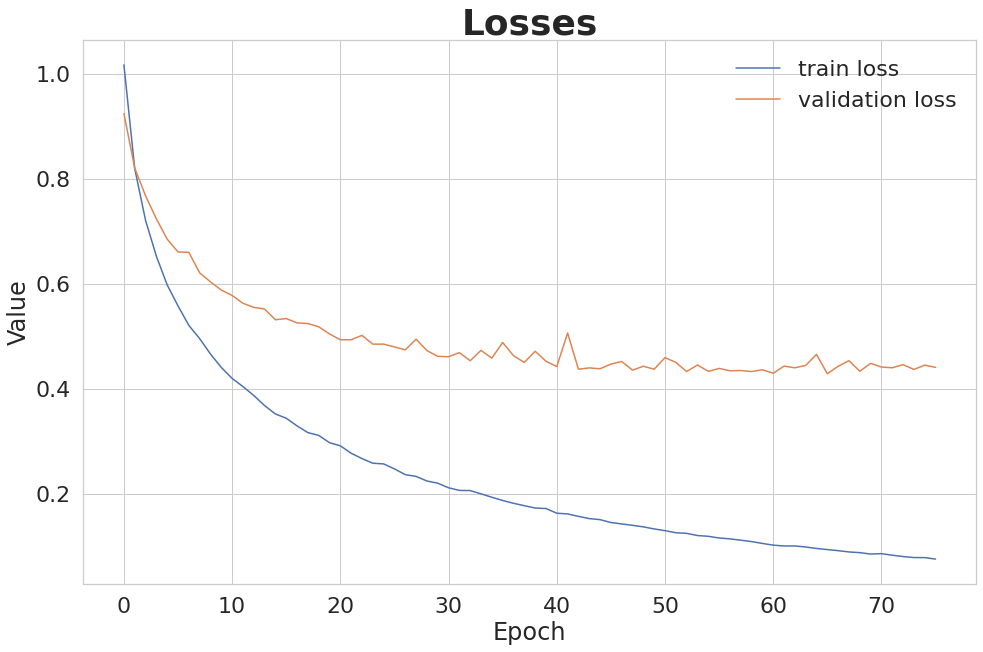

In [ ]:
# plot the loss

fig, ax = plt.subplots()
ax.set_title(label = 'Losses', size=36, weight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')

ax.plot(model.history.history['loss'], label='train loss')
ax.plot(model.history.history['val_loss'], label='validation loss')

plt.legend()
plt.savefig('LossVal_loss')
plt.show()

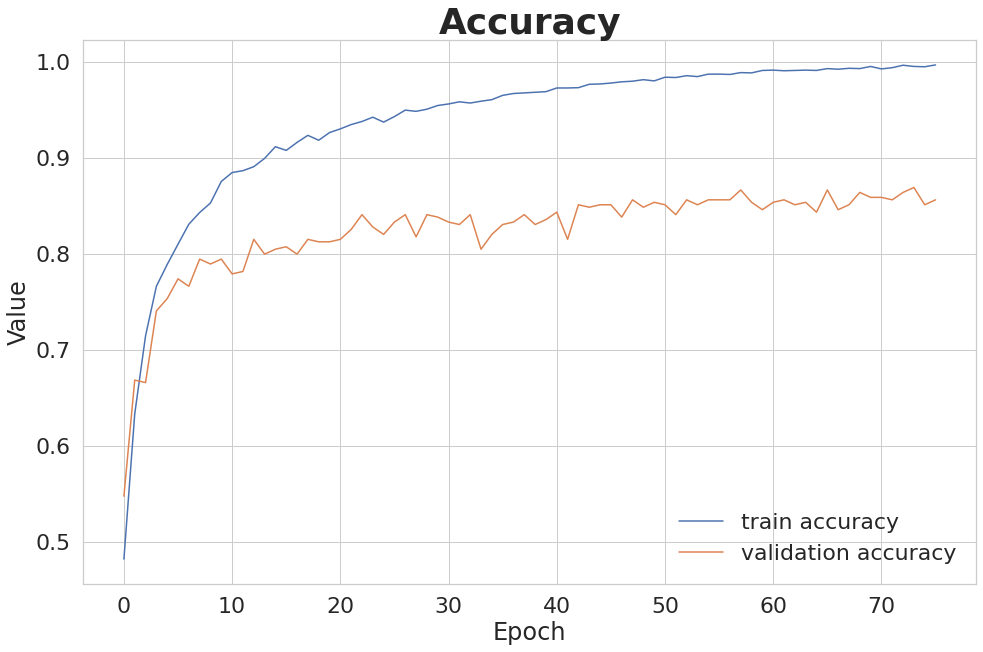

In [ ]:
# plot the accuracy
fig, ax = plt.subplots()
ax.set_title(label = 'Accuracy', size=36, weight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')

ax.plot(model.history.history['acc'], label='train accuracy')
ax.plot(model.history.history['val_acc'], label='validation accuracy')

plt.legend()
plt.savefig('Accuracy')
plt.show()

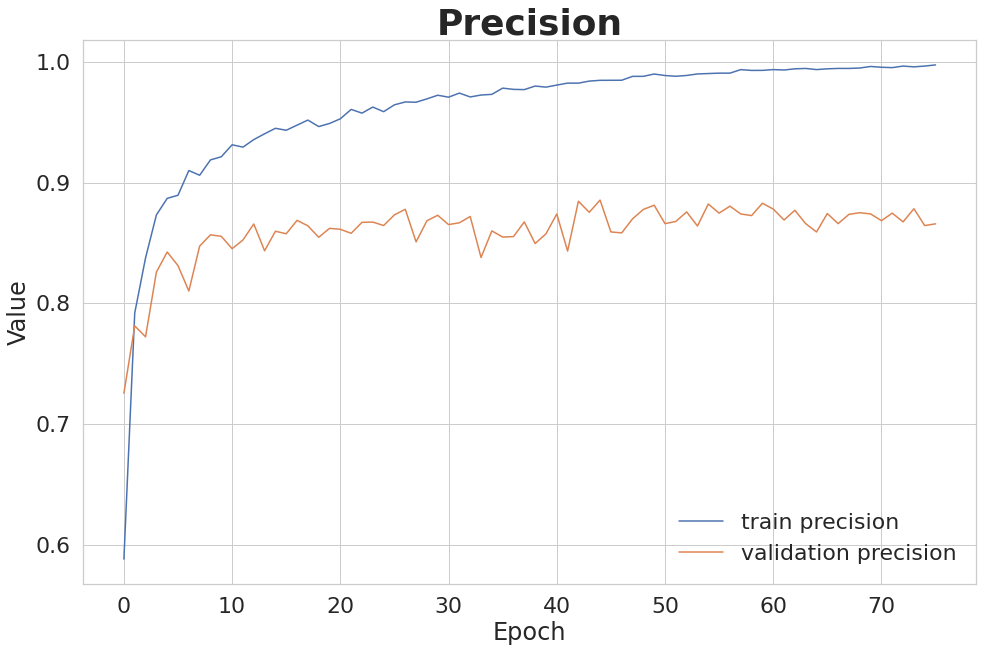

In [ ]:
# plot the precision
fig, ax = plt.subplots()
ax.set_title(label = 'Precision', size=36, weight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')

ax.plot(model.history.history['precision'], label='train precision')
ax.plot(model.history.history['val_precision'], label='validation precision')

plt.legend()
plt.savefig('Precision')
plt.show()

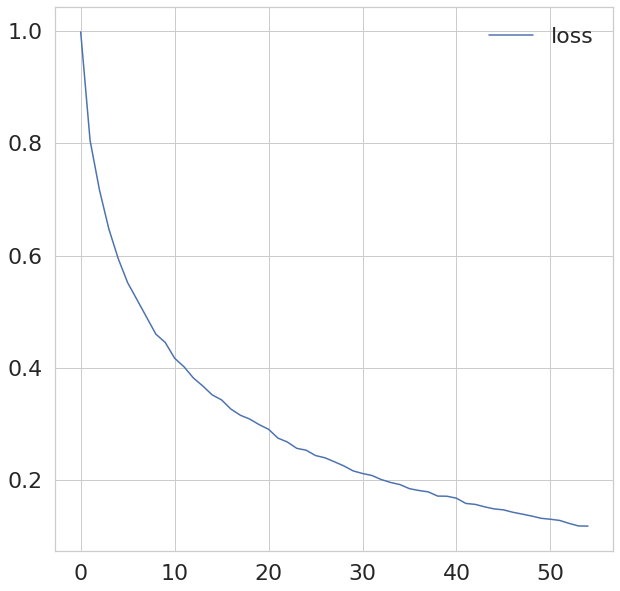

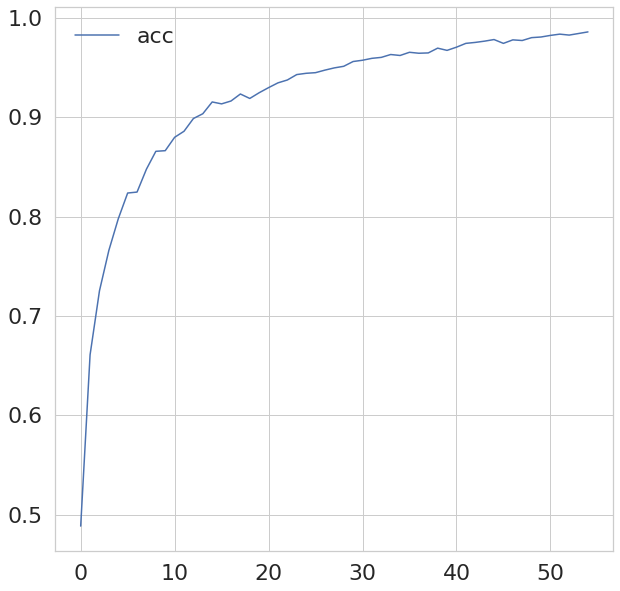

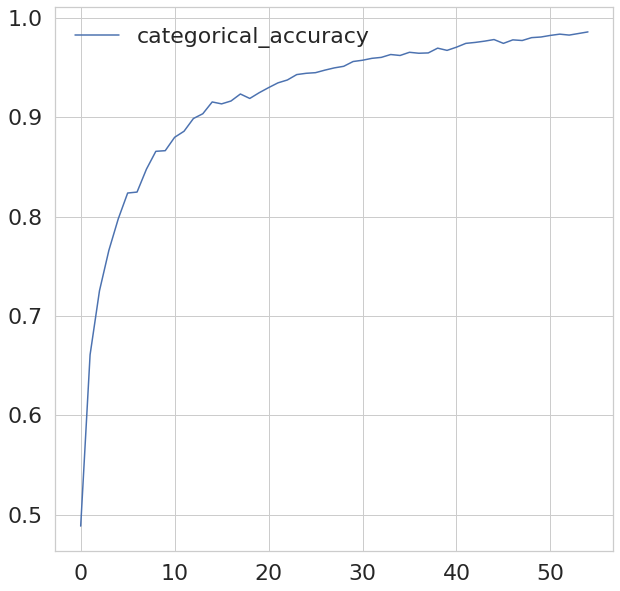

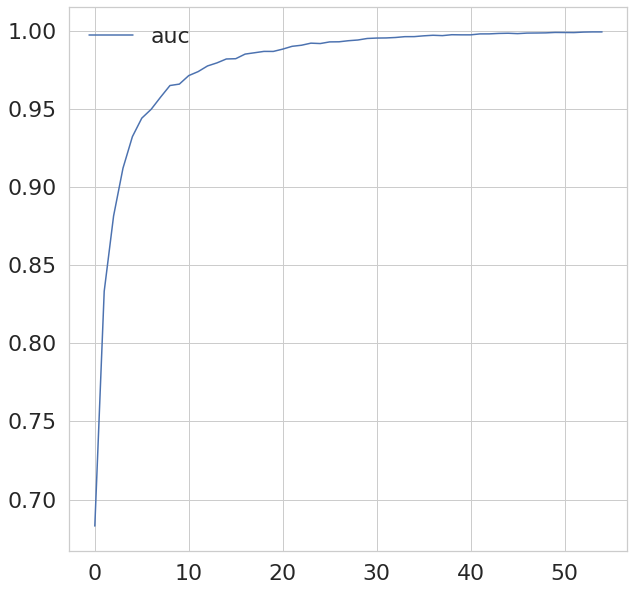

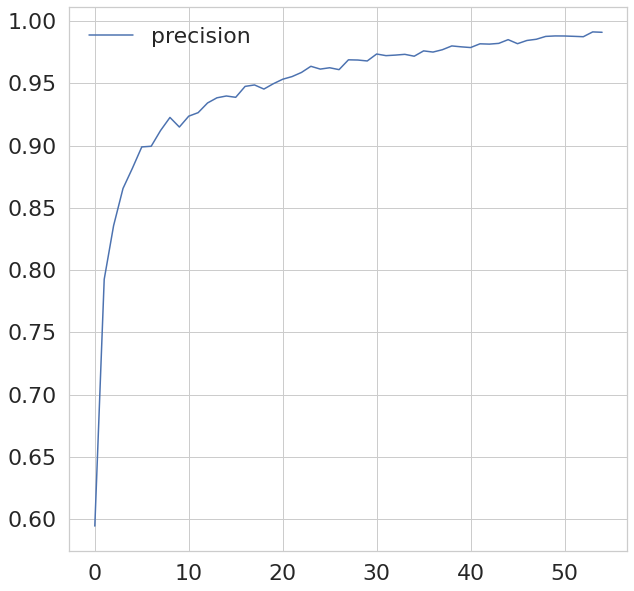

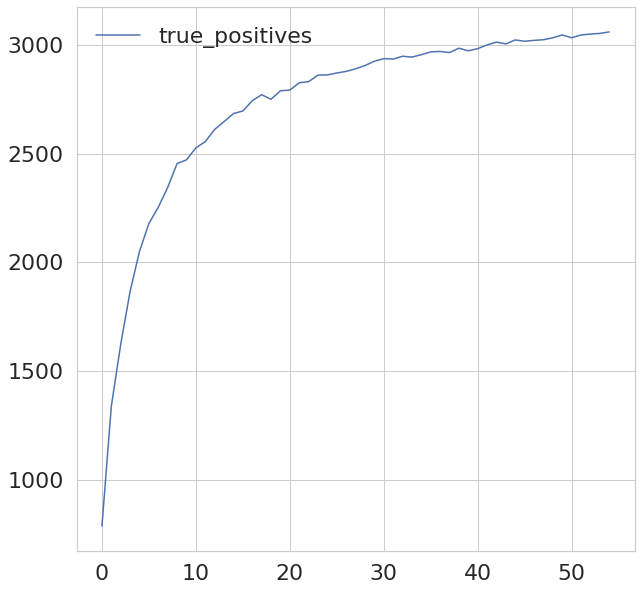

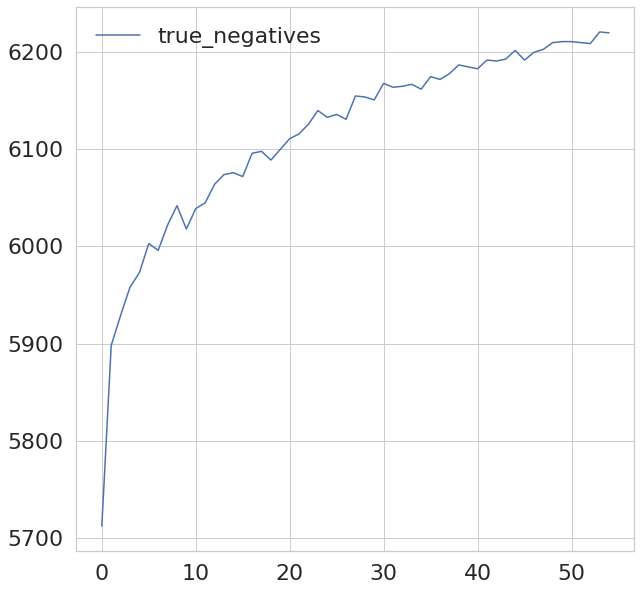

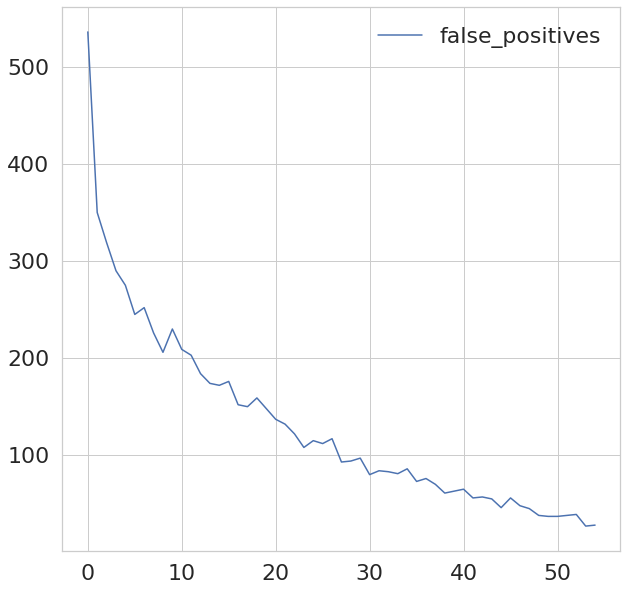

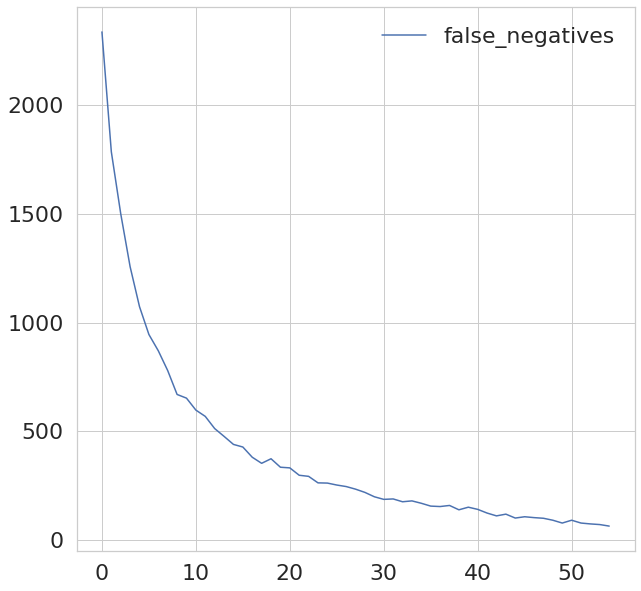

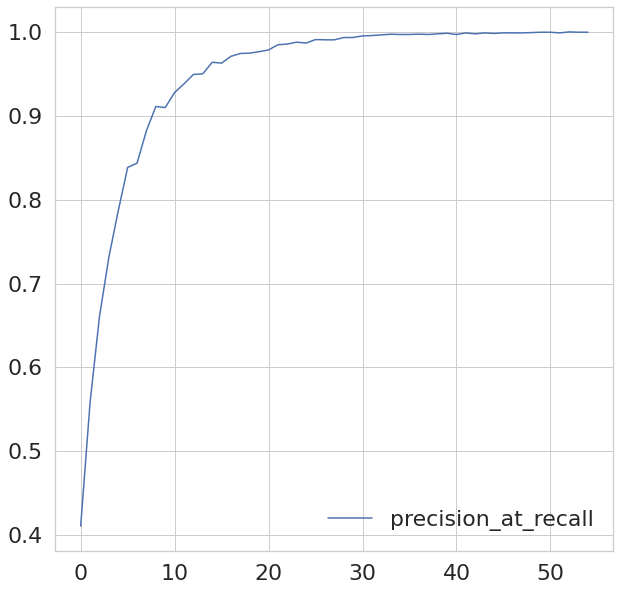

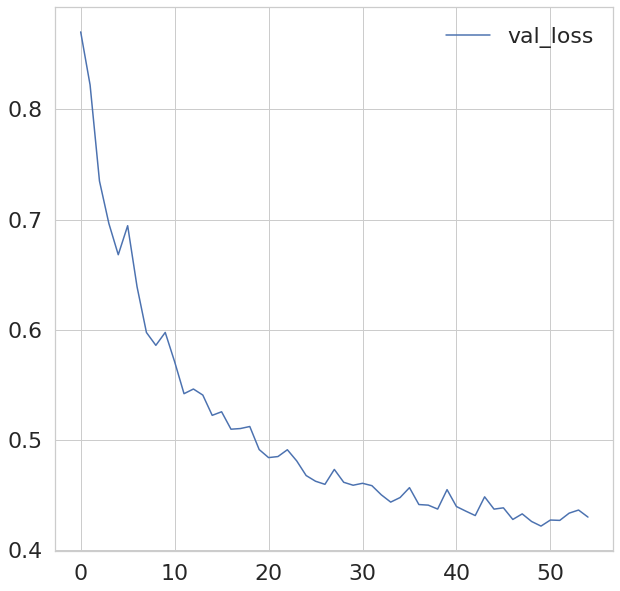

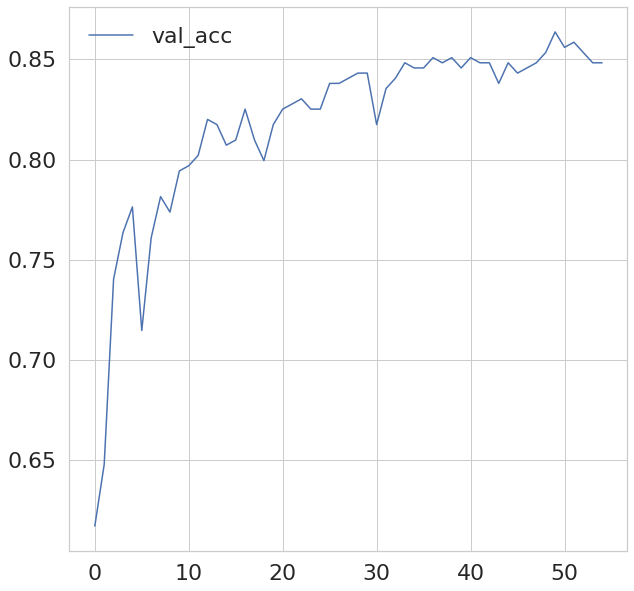

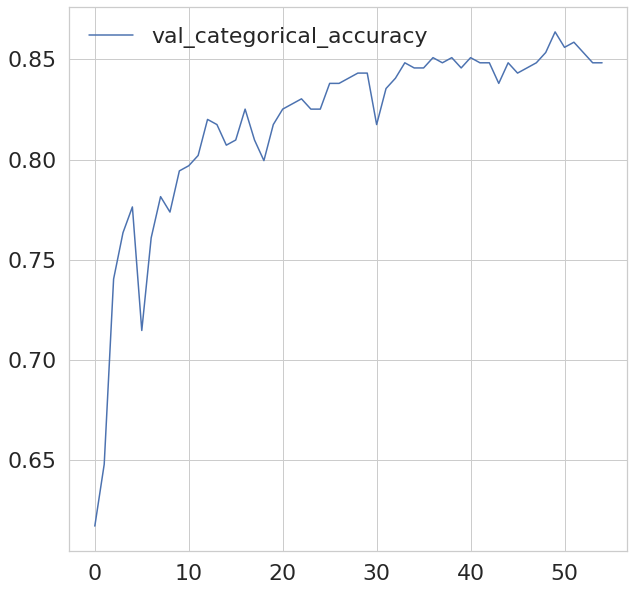

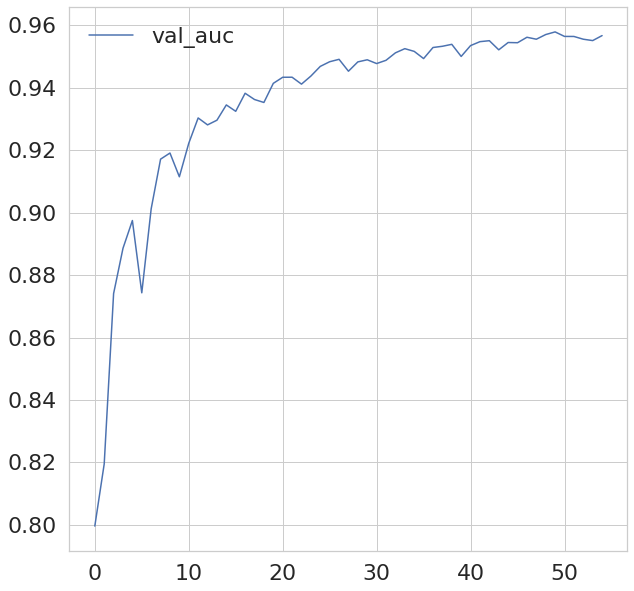

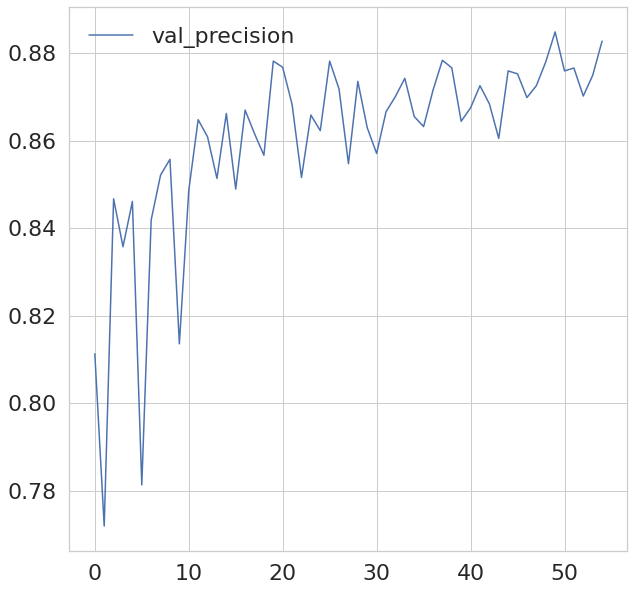

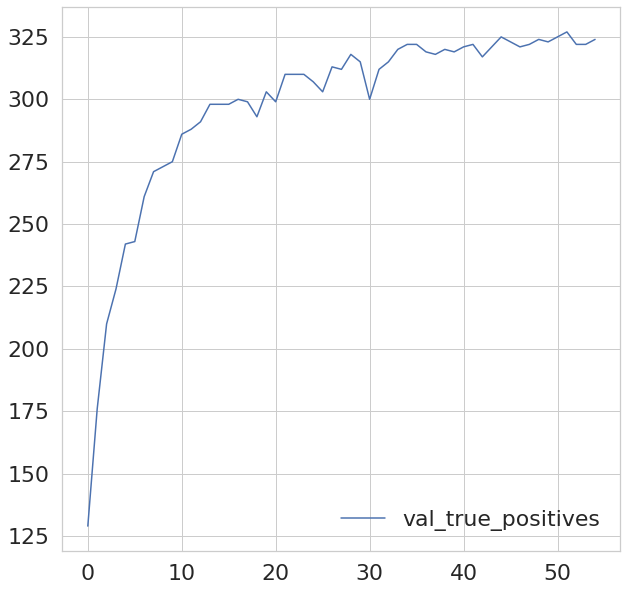

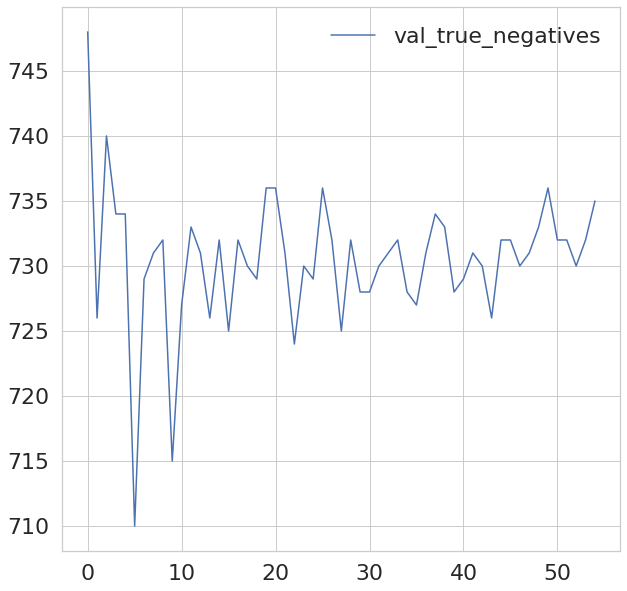

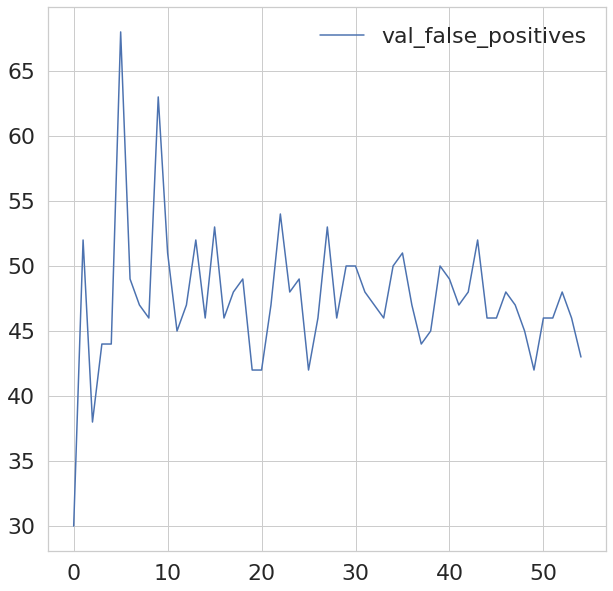

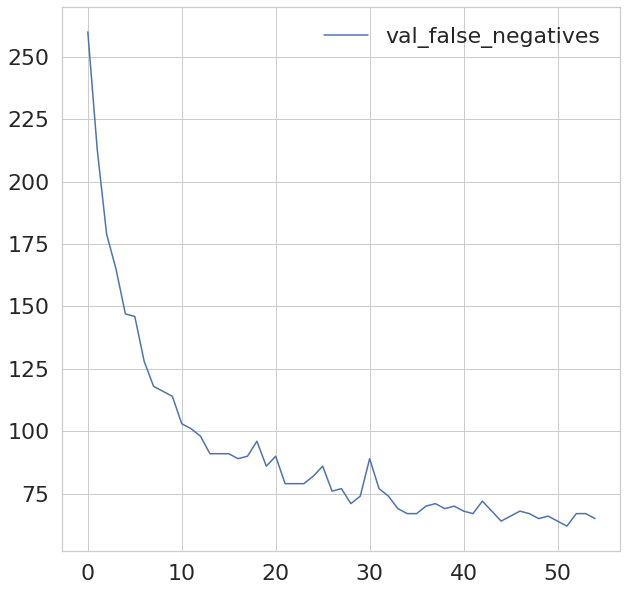

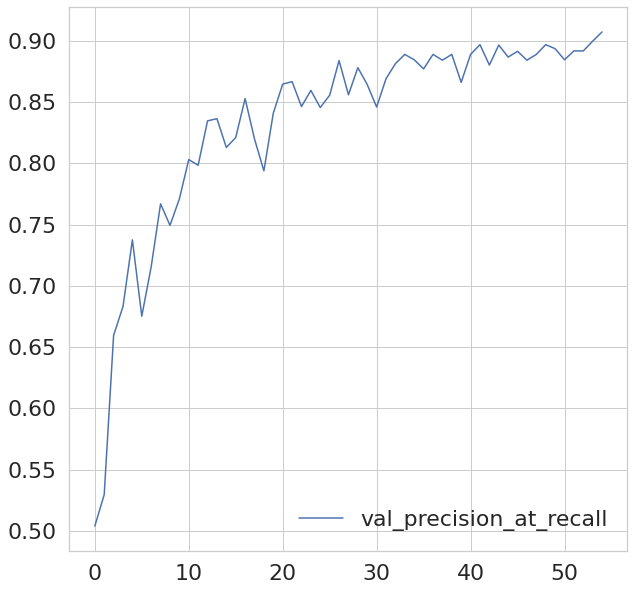

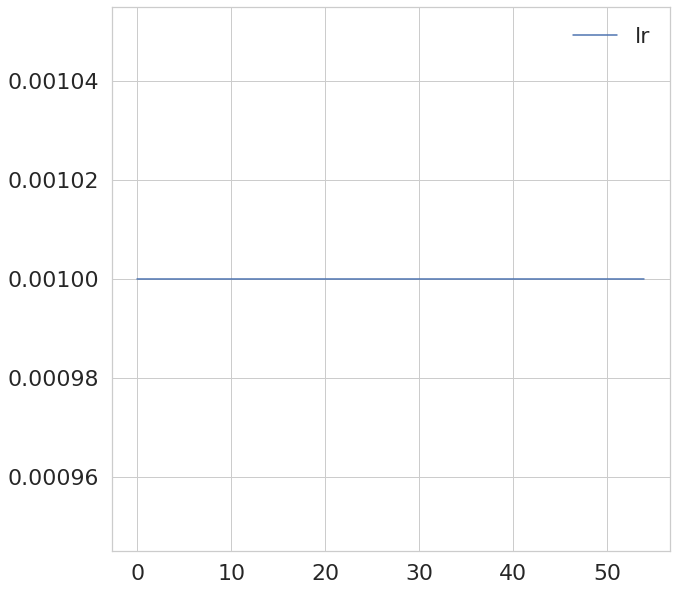

In [ ]:

for metric, values in model.history.history.items():
  plt.plot(values, label=metric)
  plt.legend()
  plt.savefig(metric)
  plt.show()

In [ ]:
# проверка на тесте

def setup1(base, prepare_image_base):
    prepare_dir_already_exists = True

    paths = []
    labels = []
    states = ['alert', 'non_vigilant', 'tired']
    for label in tqdm(states):
        temp_base = base + f'/{label}'
        prepare_image_temp_base = prepare_image_base + f'/{label}'
        for img in tqdm(os.listdir(temp_base)):

            if prepare_dir_already_exists:
              paths.append(prepare_image_temp_base + f'/{img}')
              labels.append(label)
            elif image_preparation(temp_base + f'/{img}', prepare_image_temp_base + f'/{img}') :
              paths.append(prepare_image_temp_base + f'/{img}')
              labels.append(label)

    enc = OneHotEncoder(sparse = False)
    labels = np.reshape(labels, (-1, 1))
    enc.fit(labels)
    labels = enc.transform(labels)
    return np.array(paths), labels

test_paths, test_labels = setup1(dataset_directory + '/output/test', dataset_directory + '/prepare_output/test')

def test(_labels, paths):
  labels = np.argmax(_labels, axis = 1)
  X = np.zeros((paths.shape[0], 250, 250, 3)) 
  # Generate data
  for i, path in enumerate(paths):
    X[i] = cv2.imread(path)
  predict = model.predict(X) # результаты нейронки ((0.2984, 0.3598, 0.9598), (..), ..)
  predict = np.argmax(predict, axis = 1) # результаты нейронки в формате ((0, 1, 0), (..), ..)

  result = labels == predict # сравнение с верными ответами, результат сравнения - булев массив
  true_count = sum(result)
  false_count = len(result) -  true_count
  print(f'true: {true_count}, false: {false_count}, {true_count/len(result)*100:.2f}%')
  return result

test(_labels=test_labels, paths=test_paths)



[[[[123. 119. 101.]
   [164. 160. 142.]
   [185. 184. 164.]
   ...
   [119. 116. 111.]
   [119. 114. 111.]
   [118. 113. 110.]]

  [[151. 144. 127.]
   [170. 166. 148.]
   [145. 141. 122.]
   ...
   [113. 110. 105.]
   [118. 113. 110.]
   [122. 117. 114.]]

  [[154. 146. 129.]
   [139. 132. 115.]
   [149. 145. 126.]
   ...
   [113. 113. 107.]
   [116. 113. 109.]
   [118. 115. 111.]]

  ...

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [245. 244. 234.]
   [227. 226. 216.]
   [226. 226. 214.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [239. 237. 226.]
   [226. 225. 211.]
   [225. 224. 210.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [236. 235. 221.]
   [230. 227. 213.]
   [229. 226. 211.]]]


 [[[ 42.  48.  61.]
   [ 44.  51.  66.]
   [ 51.  59.  76.]
   ...
   [107. 123. 122.]
   [106. 122. 121.]
   [106. 122. 121.]]

  [[ 51.  57.  70.]
   [ 52.  59.  74.]
   [ 58.  65.  84.]
   ...
   [107. 123. 122.]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

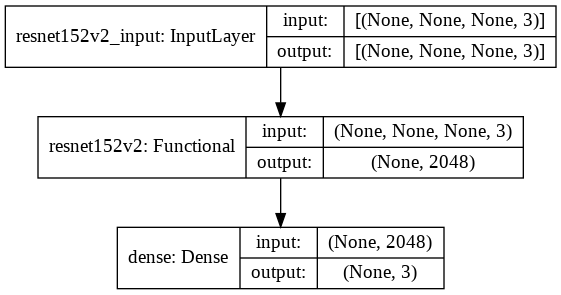

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)